# Feature Extraction (Stream Biome)

*all librosa code and feature explanation from the [CCRMA Music Information Retrieval summer intensive github repo](https://github.com/bmcfee/stanford-mir)*

In [1]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import seaborn as sns
import sklearn
import pandas as pd
plt.rcParams['figure.figsize'] = (14, 5)

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
sns.set_style('whitegrid')

# load audio

load the audio from the "forest" video:

In [4]:
sns.set_style('whitegrid')

In [5]:
x, sr = librosa.load('../../audioFiles/stream.wav')

In [ ]:
ipd.Audio(x, rate=sr)

# define helper functions to normalize

In [6]:
# normalize data between 0 and 1 for visualization
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# extract root mean square energy

In [7]:
x.shape

(3779635,)

In [8]:
hop_length = 512
frame_length = 1024

In [9]:
energy = numpy.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])

In [10]:
energy.shape

(7383,)

In [11]:
rms = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length)[0]

In [12]:
rms.shape

(7383,)

In [13]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

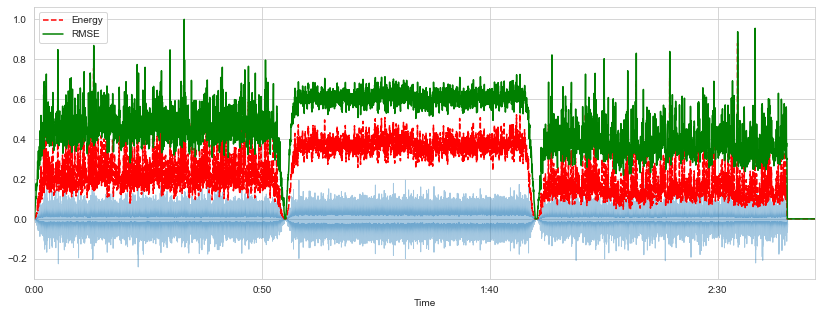

In [14]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rms)], rms/rms.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))
plt.show()

In [15]:
rms = sklearn.preprocessing.scale(rms)

/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [16]:
rms.mean()

-3.3067945e-08

In [17]:
rms.var()

1.0

# extract zero line crossing rate

Add a small constant to avoid oscillation around silence triggering high zero-crossing rate:

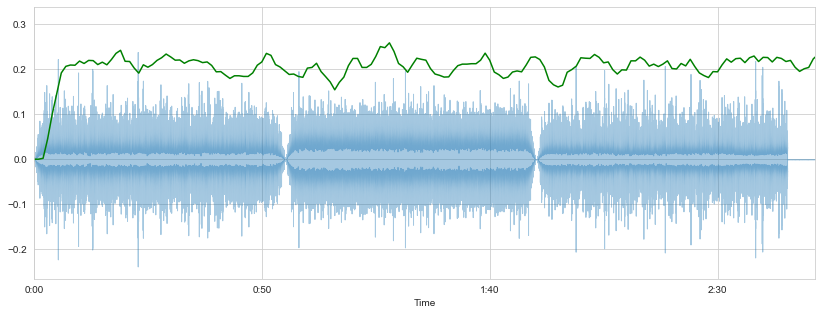

In [18]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
zcrs = librosa.feature.zero_crossing_rate(x + 0.0001)
plt.plot(zcrs[0], 'g')
plt.show()

In [19]:
zcrs.shape

(1, 7383)

# extract spectral features

### extract spectral centroid

The **spectral centroid** ([Wikipedia](https://en.wikipedia.org/wiki/Spectral_centroid)) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:

$$ f_c = \frac{\sum_k S(k) f(k)}{\sum_k S(k)} $$

where $S(k)$ is the spectral magnitude at frequency bin $k$, $f(k)$ is the frequency at bin $k$.

[`librosa.feature.spectral_centroid`](https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html#librosa.feature.spectral_centroid) computes the spectral centroid for each frame in a signal:

In [20]:
spectral_centroids = librosa.feature.spectral_centroid(x+0.01, sr=sr)[0] # add constant to correct value at silence

In [21]:
# calculate time variable for plotting
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

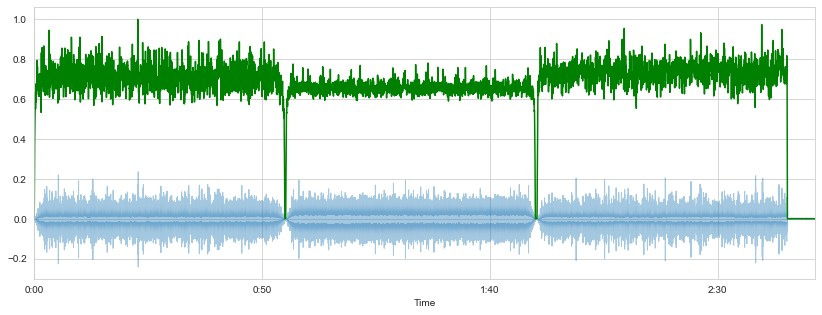

In [22]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='g') # normalize for visualization purposes
plt.show()

In [23]:
spectral_centroids = sklearn.preprocessing.scale(spectral_centroids)

In [24]:
spectral_centroids.mean()

2.7717229838671117e-16

In [25]:
spectral_centroids.var()

1.0

### extract spectral bandwidth

[`librosa.feature.spectral_bandwidth`](https://librosa.github.io/librosa/generated/librosa.feature.spectral_bandwidth.html#librosa.feature.spectral_bandwidth) computes the order-$p$ spectral bandwidth:

$$ \left( \sum_k S(k) \left(f(k) - f_c \right)^p \right)^{\frac{1}{p}} $$

where $S(k)$ is the spectral magnitude at frequency bin $k$, $f(k)$ is the frequency at bin $k$, and $f_c$ is the spectral centroid. When $p = 2$, this is like a weighted standard deviation.

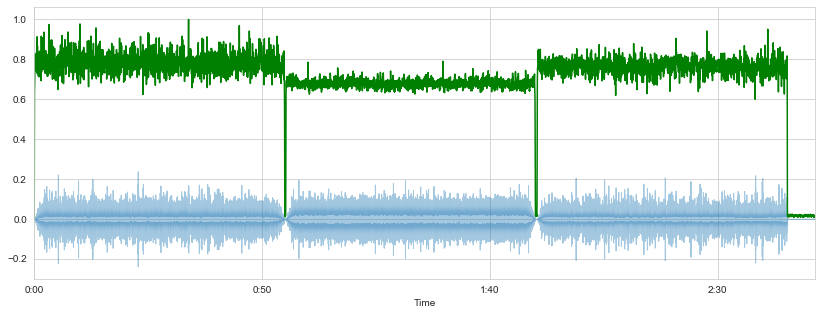

In [26]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='g')
plt.show()

In [27]:
spectral_bandwidth_2 = sklearn.preprocessing.scale(spectral_bandwidth_2)

In [28]:
spectral_bandwidth_2.mean()

1.5398461021483954e-17

In [29]:
spectral_bandwidth_2.var()

0.9999999999999997

### extract spectral rolloff

**Spectral rolloff** is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

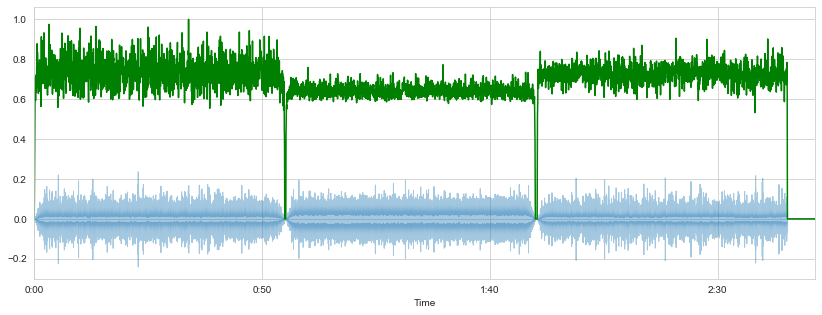

In [30]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='g')
plt.show()

In [31]:
spectral_rolloff = sklearn.preprocessing.scale(spectral_rolloff)

In [32]:
spectral_rolloff.mean()

-9.239076612890372e-17

In [33]:
spectral_rolloff.var()

1.0000000000000002

### extract spectral novelty

We will compute a **spectral novelty function** ([FMP](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html), p. 309):

1.  Compute the log-amplitude spectrogram.
2.  Within each frequency bin, $k$, compute the energy novelty function as shown earlier, i.e. (a) first-order difference, and (b) half-wave rectification.
3.  Sum across all frequency bins, $k$.

In [34]:
spectral_novelty = librosa.onset.onset_strength(x, sr=sr)

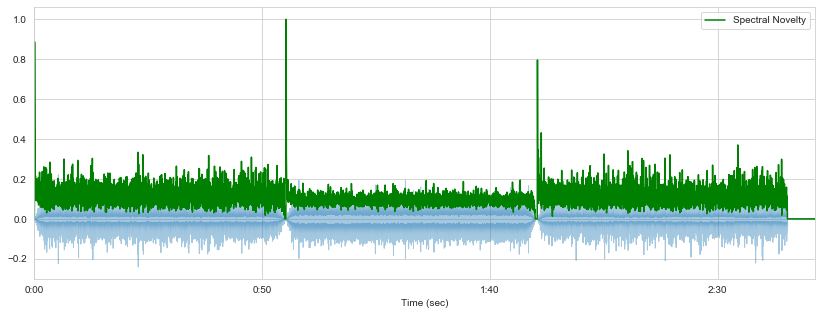

In [35]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_novelty), 'g')
plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('Spectral Novelty',))
plt.show()

In [36]:
spectral_novelty = sklearn.preprocessing.scale(spectral_novelty)

/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [37]:
spectral_novelty.mean()

8.266986e-09

In [38]:
spectral_novelty.var()

1.0000001

### Extract Mel Frequency Cepstral Coefficients (MFCCs)

MFCCs 

In [39]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

(20, 7383)


display MFCCs:

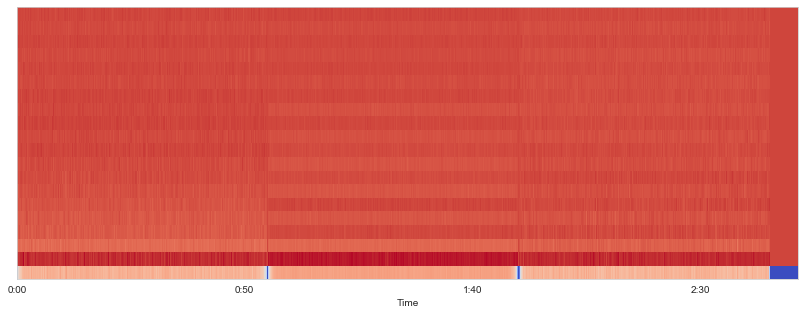

In [40]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

Let's scale the MFCCs such that each coefficient dimension has zero mean and unit variance:

In [41]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[-1.3317597e-07  1.4189506e-07 -1.4983911e-08 -2.9887090e-08
  7.8988464e-08 -1.0955371e-07 -1.9149697e-08  2.4219684e-09
  7.1173581e-08  3.3407019e-08  1.7360671e-07  7.2901254e-09
  2.9354258e-08 -6.0307016e-08  2.6270286e-07  1.2084008e-07
  2.7126048e-09 -1.3974758e-08  9.1066013e-08  5.6456084e-08]
[1.0000074  0.999995   1.0000005  1.0000002  1.0000111  0.9999912
 0.999998   0.999994   1.0000038  1.0000137  0.9999954  1.0000019
 0.99999094 0.9999992  1.0000032  1.0000015  0.99999493 0.9999893
 1.0000045  0.9999966 ]


/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Display all the scaled MFCCs:

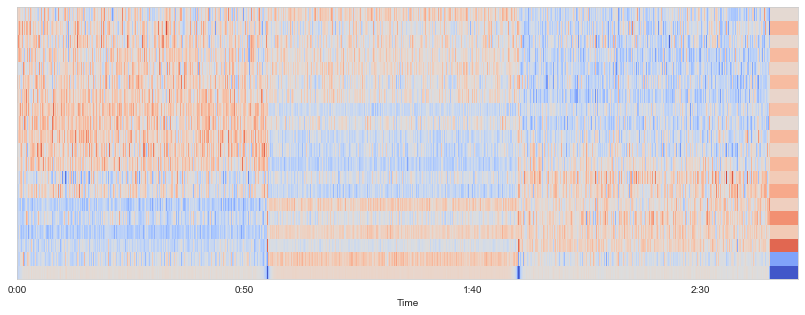

In [42]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

Pull out one MFCC:

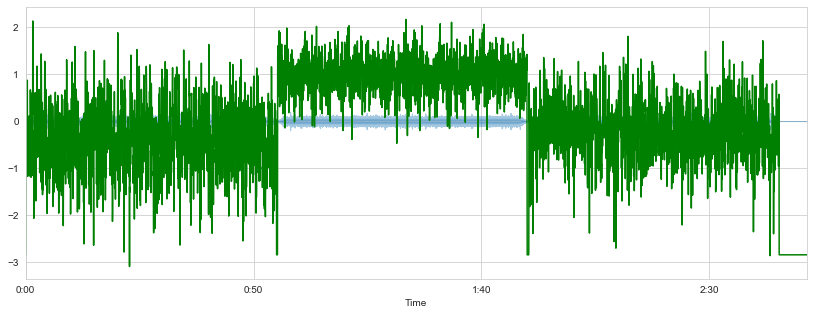

In [43]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, mfccs[1], color='g')
plt.show()

# Create Feature Vector

Append spectral features to MFCCs as new rows of the array:

In [44]:
def add_second_dimension_to_array(the_array):
    cols = the_array.shape[0]
    return numpy.reshape(the_array, (-1, cols))

In [45]:
mfccs.shape

(20, 7383)

In [46]:
mfccs.shape

(20, 7383)

In [47]:
spectral_features = [
rms,
spectral_centroids,
spectral_bandwidth_2,
spectral_rolloff,
spectral_novelty,
]

In [48]:
X = mfccs
for feature in spectral_features:
    X = numpy.append(X, add_second_dimension_to_array(feature), axis=0)

In [49]:
X.shape

(25, 7383)

features 0-19 are MFCCs, after which:
* index 20: RMS
* index 21: spectral centroid
* index 22: spectral bandwidth
* index 23: spectral rolloff
* index 24: spectral novelty

# Apply Principal Component Analysis to See Which Features Predict the Signal Most

In [50]:
X.mean()

9.071877644582814e-09

In [51]:
model = sklearn.decomposition.PCA(n_components=2, whiten=True)

In [52]:
model.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [53]:
Y = model.transform(X.T)

In [54]:
print(Y.shape)

(7383, 2)


In [55]:
model.components_.shape

(2, 25)

In [56]:
component_magnitudes = pd.DataFrame(model.components_, index = ['PC-1','PC-2'])
component_magnitudes = abs(component_magnitudes)

In [57]:
component_magnitudes.iloc[0].sort_values(ascending=False)

0     0.384776
21    0.339841
22    0.328468
23    0.326242
20    0.282515
1     0.276542
2     0.240512
6     0.202492
8     0.194070
4     0.188896
10    0.186331
12    0.172558
18    0.159388
24    0.157670
14    0.152676
16    0.141043
9     0.105428
7     0.089900
13    0.065953
15    0.064510
17    0.063470
11    0.060079
5     0.014149
19    0.010643
3     0.004849
Name: PC-1, dtype: float64

In [58]:
component_magnitudes.iloc[1].sort_values(ascending=False)

3     0.373545
5     0.335673
12    0.296699
13    0.279553
11    0.262674
2     0.259134
10    0.255608
4     0.254542
9     0.216681
15    0.216339
14    0.214554
16    0.174983
17    0.167322
8     0.138192
7     0.133033
22    0.128358
18    0.120628
23    0.111337
20    0.095983
24    0.090127
19    0.082456
0     0.072669
21    0.065581
1     0.042301
6     0.034741
Name: PC-2, dtype: float64

For the stream biome's audio:

Component 1 depends substantially on RMS energy, spectral centroid, spectral bandwidth, and spectral rolloff (but not spectral novelty).

Component 2 depends largely on MFCCs 4, 6, 13, 14, and 12.

# Signal Decomposition via Non-Negative Matrix Factorization

In [59]:
S = librosa.stft(x)
print(S.shape)

(1025, 7383)


/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/librosa/core/spectrum.py:1700: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


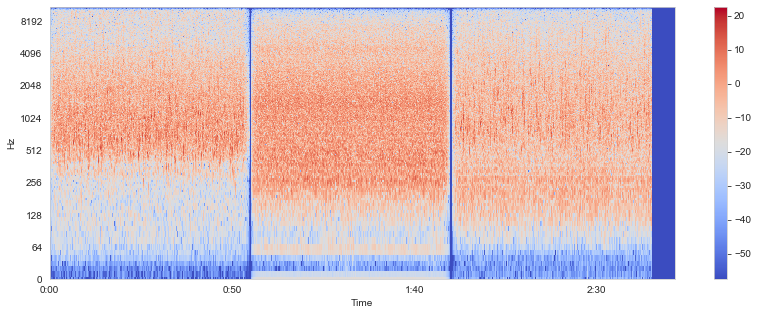

In [60]:
Smag = librosa.amplitude_to_db(S)
librosa.display.specshow(Smag, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [61]:
X = numpy.absolute(S)
n_components = 6
W, H = librosa.decompose.decompose(X, n_components=n_components, sort=True)
print(W.shape)
print(H.shape)

(1025, 6)
(6, 7383)


Plot each spectral component:

/Users/trqk-data/.local/share/virtualenvs/nature-nurtures--FcyQ97q/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


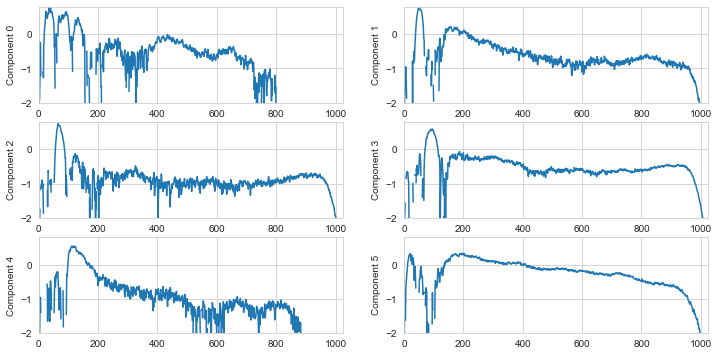

In [62]:
plt.figure(figsize=(12, 6))
logW = numpy.log10(W)
for n in range(n_components):
    plt.subplot(numpy.ceil(n_components/2.0), 2, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-2, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)

temporal activations of each component:

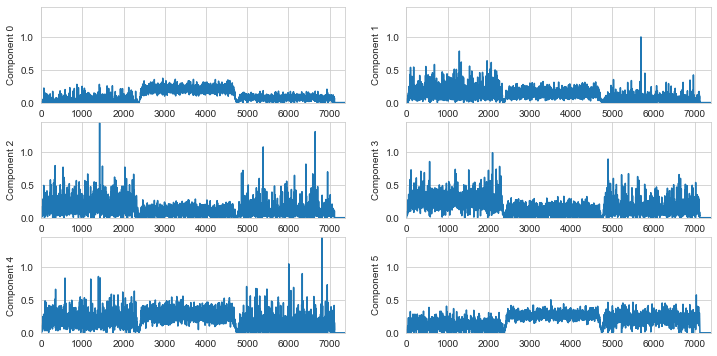

In [63]:
plt.figure(figsize=(12, 6))
for n in range(n_components):
    plt.subplot(numpy.ceil(n_components/2.0), 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

Listen to components:

In [ ]:
reconstructed_signal = scipy.zeros(len(x))
for n in range(n_components):
    Y = scipy.outer(W[:,n], H[n])*numpy.exp(1j*numpy.angle(S))
    y = librosa.istft(Y)
    reconstructed_signal[:len(y)] += y
    ipd.display( ipd.Audio(y, rate=sr) )

Reconstructed full mix:

In [ ]:
ipd.Audio(reconstructed_signal, rate=sr)

residual:

In [ ]:
residual = x - reconstructed_signal
residual[0] = 1 # hack to prevent automatic gain scaling
ipd.Audio(residual, rate=sr)